In [11]:
import torch
import wandb
import torchvision

import numpy as np

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [24]:
device = torch.device('cuda')
classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./ddpm_checkpoints/classifier.pth'))
#noisy_classifier.eval()

clean_classifier = ResNet(**classifier_args)
clean_classifier.to(device)

clean_classifier.load_state_dict(torch.load('./ddpm_checkpoints/clean_classifier.pth'))
clean_classifier.eval()
5

5

#### Создайте два семплемера картинок, безусловный и условный с методом .set_classifier

In [21]:
conditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)
conditional_diffusion.set_classifier(noisy_classifier, T=1.)

unconditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)

In [15]:
def get_pred_labels(images_normed: torch.Tensor):
    """
    predict labels for normed images 
    [-1, 1]
    """
    outputs = clean_classifier(images_normed)
    _, predicted = torch.max(outputs.data, 1)
    return predicted


def calc_acc_clean_classifier(images_normed: torch.Tensor, labels: torch.Tensor):
    """
    calculate accuracy using clean classifier
    """
    predicted = get_pred_labels(images_normed)
    accuracy = (predicted==labels).sum() / len(labels)
    return accuracy


def sample_images(diff_process, labels=None):
    images_tensor = diff_process.sample_images(batch_size=100, labels=labels)
    images_cpu = images_tensor.cpu()
    grid = torchvision.utils.make_grid(images_cpu, nrow=10).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)

    plt.imshow(grid)
    plt.show()
    return images_tensor


def cond_print_and_calc_acc(class_num: int):
    labels = class_num*torch.ones(100).long().to(device)
    images_tensor = sample_images(conditional_diffusion, labels)
    acc = calc_acc_clean_classifier((images_tensor - 127.5)/ 127.5, labels=labels)
    print('Accuracy: ', acc.item())
    return images_tensor

#### Посемплируйте наборы картинок всех классов обоими способами, изменить температуру можно с помощью повторного .set_classifier

> Как сильно влияет температура на отличимость семплов при условной генерации? Продеменстрируйте для разных T свои выводы.



> Какое качество получается у чистого классификатора при условной генерации? Попробуйте оценить на глаз качество чистого классификатора для безусловной генерации, объясните свои выводы.


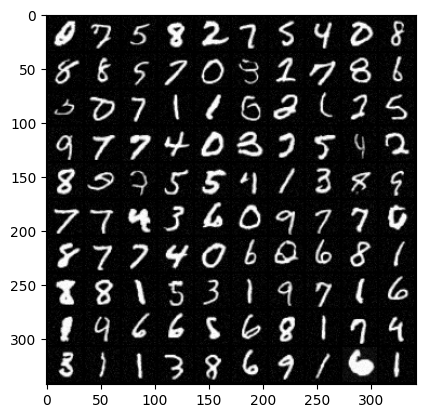

In [12]:
imges = sample_images(unconditional_diffusion, labels=torch.arange(10))

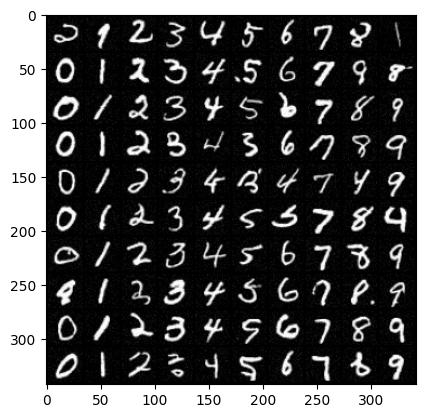

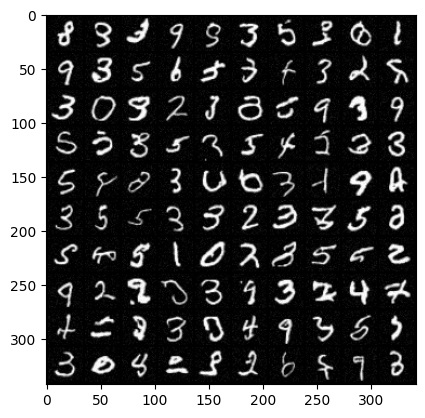

Accuracy:  0.32999998331069946


In [26]:
conditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)
conditional_diffusion.set_classifier(noisy_classifier, T=1.)
imges = sample_images(conditional_diffusion, labels=torch.tensor(list(range(10))*10).cuda())
images = cond_print_and_calc_acc(3)

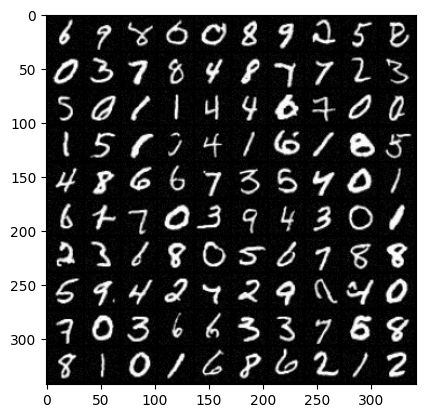

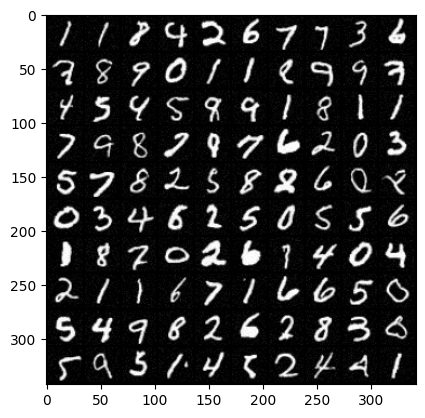

Accuracy:  0.04999999701976776


In [27]:
conditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)
conditional_diffusion.set_classifier(noisy_classifier, T=10.)
imges = sample_images(conditional_diffusion, labels=torch.tensor(list(range(10))*10).cuda())
images = cond_print_and_calc_acc(3)

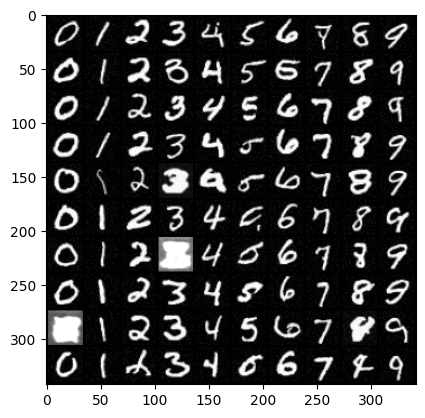

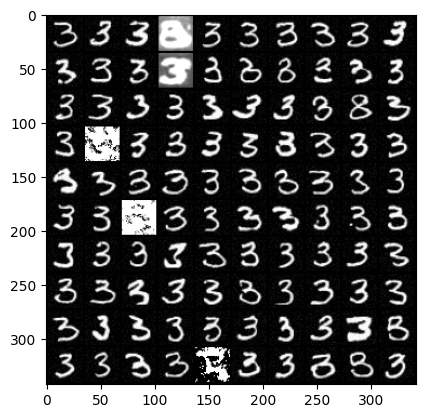

Accuracy:  0.9099999666213989


In [28]:
conditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)
conditional_diffusion.set_classifier(noisy_classifier, T=0.1)
imges = sample_images(conditional_diffusion, labels=torch.tensor(list(range(10))*10).cuda())
images = cond_print_and_calc_acc(3)

Видно, что при более низких значениях температуры (0.1) изображения получаются менее качественными. Однако при большой температуре(10) условие "затирается" и условная генерация превращается в безусловную. Заметно, что при Т=1, условия сохраняются, и при этом качество относительно неплохое (хотя при просьбе сгенерировать цифру 3 нейронная сеть справилась не очень хорошо). Безусловная генерация работает довольно хорошо, изображения получаются различные и качественные.